### Student Information
Name: 徐偉晉

Student ID: 109022127

GitHub ID: Wayne48763

Kaggle name: WayneHsu123

Kaggle private scoreboard snapshot:

![Snapshot](img/pic0.png)

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home** exercises in the DM2023-Lab2-master. You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/t/09b1d0f3f8584d06848252277cb535f2) regarding Emotion Recognition on Twitter by this link https://www.kaggle.com/t/09b1d0f3f8584d06848252277cb535f2. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (60-x)/6 + 20 points, where x is your ranking in the leaderboard (ie. If you rank 3rd your score will be (60-3)/6 + 20 = 29.5% out of 30%)   
    Submit your last submission __BEFORE the deadline (Dec. 27th 11:59 pm, Wednesday)_. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developping the model for the competition (You can use code and comment it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook** and **add minimal comments where needed**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Dec. 31th 11:59 pm, Sunday)__. 

In [13]:
### Begin Assignment Here
import pandas as pd
import numpy as np
import nltk
from IPython.display import display
import matplotlib.pyplot as plt

# Load Data

In [2]:
df_id = pd.read_csv('data/data_identification.csv')
df_emotion = pd.read_csv('data/emotion.csv')
df_tweets = pd.read_json('data/tweets_DM.json', lines=True)

In [3]:
display(df_id.head())
display(df_emotion.head())
display(df_tweets.head())

print(df_id.shape)
print(df_emotion.shape)
print(df_tweets.shape)

,tweet_id,identification
0,0x28cc61,test
1,0x29e452,train
2,0x2b3819,train
3,0x2db41f,test
4,0x2a2acc,train


,tweet_id,emotion
0,0x3140b1,sadness
1,0x368b73,disgust
2,0x296183,anticipation
3,0x2bd6e1,joy
4,0x2ee1dd,anticipation


,_score,_index,_source,_crawldate,_type
0,391,hashtag_tweets,"{'tweet': {'hashtags': ['Snapchat'], 'tweet_id...",2015-05-23 11:42:47,tweets
1,433,hashtag_tweets,"{'tweet': {'hashtags': ['freepress', 'TrumpLeg...",2016-01-28 04:52:09,tweets
2,232,hashtag_tweets,"{'tweet': {'hashtags': ['bibleverse'], 'tweet_...",2017-12-25 04:39:20,tweets
3,376,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x1cd5...",2016-01-24 23:53:05,tweets
4,989,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x2de2...",2016-01-08 17:18:59,tweets


(1867535, 2)
(1455563, 2)
(1867535, 5)


# Preprocessing

In [4]:
def read_source(row):
    hashtags = row['tweet']['hashtags']
    text = row['tweet']['text']
    tweet_id = row['tweet']['tweet_id']
    return tweet_id, hashtags, text

In [5]:
# retrieve data from dictionary
df_data = pd.DataFrame()
df_data['tweet_id'], df_data['hashtags'], df_data['text'] = zip(*df_tweets['_source'].apply(read_source))
df_data.head()

,tweet_id,hashtags,text
0,0x376b20,[Snapchat],"People who post ""add me on #Snapchat"" must be ..."
1,0x2d5350,"[freepress, TrumpLegacy, CNN]","@brianklaas As we see, Trump is dangerous to #..."
2,0x28b412,[bibleverse],"Confident of your obedience, I write to you, k..."
3,0x1cd5b0,[],Now ISSA is stalking Tasha 😂😂😂 <LH>
4,0x2de201,[],"""Trust is not the same as faith. A friend is s..."


In [6]:
# merger id, emotion and data
df_data = df_data.merge(df_id, on='tweet_id', how='left')
df_data = df_data.merge(df_emotion, on='tweet_id', how='left')
df_data.head()

,tweet_id,hashtags,text,identification,emotion
0,0x376b20,[Snapchat],"People who post ""add me on #Snapchat"" must be ...",train,anticipation
1,0x2d5350,"[freepress, TrumpLegacy, CNN]","@brianklaas As we see, Trump is dangerous to #...",train,sadness
2,0x28b412,[bibleverse],"Confident of your obedience, I write to you, k...",test,NaN
3,0x1cd5b0,[],Now ISSA is stalking Tasha 😂😂😂 <LH>,train,fear
4,0x2de201,[],"""Trust is not the same as faith. A friend is s...",test,NaN


In [11]:
# print the shape of the data
df_train = df_data[df_data['identification'] == 'train']
df_test = df_data[df_data['identification'] == 'test']
print(df_train.shape)
print(df_test.shape)

(1455563, 6)
(411972, 6)


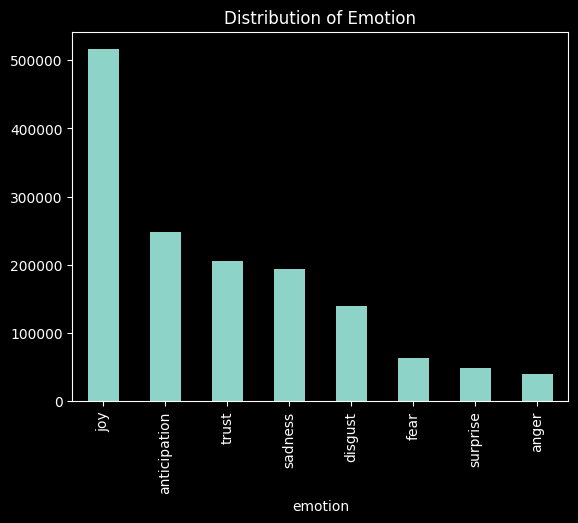

emotion
joy             516017
anticipation    248935
trust           205478
sadness         193437
disgust         139101
fear             63999
surprise         48729
anger            39867
Name: count, dtype: int64

In [16]:
# show the distribution of emotion
df_train['emotion'].value_counts().plot(kind='bar')
plt.title('Distribution of Emotion')
plt.show()
df_train['emotion'].value_counts()

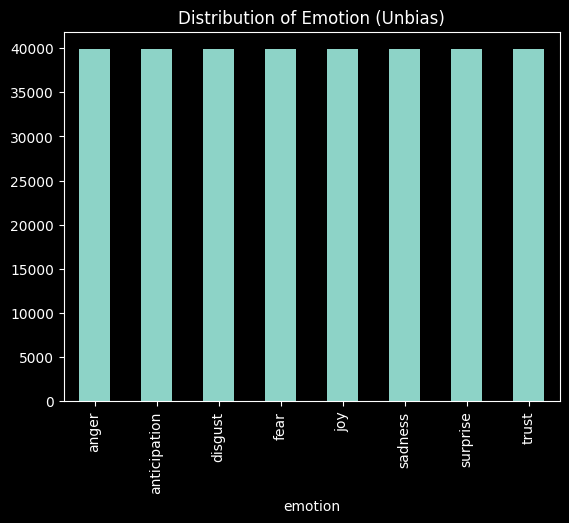

In [18]:
# unbias the data (downsampling to the minimum number of emotion)
min_num = df_train['emotion'].value_counts().min()
df_train_unbias = df_train.groupby('emotion').apply(lambda x: x.sample(min_num)).reset_index(drop=True)
df_train_unbias['emotion'].value_counts().plot(kind='bar')
plt.title('Distribution of Emotion (Unbias)')
plt.show()

# Save Data

In [ ]:
# save as pickle
df_train.to_pickle('data/train.pkl')
df_train_unbias.to_pickle('data/train_unbias.pkl')
df_test.to_pickle('data/test.pkl')